In [1]:
import keras
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
keras.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

'2.3.1'

Data preprocessing

In [2]:
import numpy as np
import pickle
def getData(datasetName):
    with open(datasetName,'rb') as file_in:
#         features, labels, setups, cameras, performers, replications = pickle.load(file_in)
        train_set, val_set, test_set = pickle.load(file_in)
    
    #### stats ################################
    nOfZeros = np.count_nonzero(train_set[0]==0)
    nOfZeros += np.count_nonzero(val_set[0]==0)
    nOfZeros += np.count_nonzero(test_set[0]==0)
    print("number of zeros(before padding): {}".format(nOfZeros))
    print("Train dataset shape: ", train_set[0].shape)
    print("Validation dataset shape: ", val_set[0].shape)
    print("Test dataset shape: ", test_set[0].shape)
    return train_set, val_set, test_set

In [3]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encoding(labels):
    encoder = LabelBinarizer()
    label_strings = [str(i) for i in labels]
    oneHotLabels = encoder.fit_transform(label_strings)
    print('classes order:', encoder.classes_) 
    return oneHotLabels
    
from sklearn.model_selection import StratifiedShuffleSplit
def balancedSplitting(features, labels, test_size = 0.5):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size)
    for train_idx, test_idx in sss.split(features, labels):
        X_train = features[train_idx]
        y_train = labels[train_idx]
        X_test = features[test_idx]
        y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test
    
    
from keras.preprocessing.sequence import pad_sequences
def padding(features, max):
    maxLength = max([len(s) for s in  features])
    newFeatures = pad_sequences(features, maxlen=None, dtype='float32', padding='post', truncating='post', value=0.0)
    lenght = newFeatures.shape[0] * newFeatures.shape[1]*newFeatures.shape[2]*newFeatures.shape[3]
    numberOfZeros = np.count_nonzero(newFeatures==0)
    print("number of zeros(after padding): {} - {:.2f}%".format(numberOfZeros, numberOfZeros/(lenght)*100))
    print("Dataset shape: ", newFeatures.shape)
    return newFeatures

def paddingTrainValTest(X_train, X_val, X_test, maxLength=None):
    if maxLength is None:
        maxLength = max([len(s) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    newXtrain = pad_sequences(X_train, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    newXval = pad_sequences(X_val, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    newXtest = pad_sequences(X_test, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    lenghtTrain = newXtrain.shape[0] * newXtrain.shape[1]*newXtrain.shape[2]*newXtrain.shape[3]
    lenghtVal = newXval.shape[0] * newXval.shape[1]*newXval.shape[2]*newXval.shape[3]
    lenghtTest = newXtest.shape[0] * newXtest.shape[1]*newXtest.shape[2]*newXtest.shape[3]
    numberOfZerosTrain = np.count_nonzero(newXtrain==0)
    numberOfZerosVal = np.count_nonzero(newXval==0)
    numberOfZerosTest = np.count_nonzero(newXtest==0)
    print("number of zeros train (after padding):\t\t{} - {:.2f}%".format(numberOfZerosTrain, numberOfZerosTrain/(lenghtTrain)*100))
    print("number of zeros validation (after padding):\t{} - {:.2f}%".format(numberOfZerosVal, numberOfZerosVal/(lenghtVal)*100))
    print("number of zeros test (after padding):\t\t{} - {:.2f}%".format(numberOfZerosTest, numberOfZerosTest/(lenghtTest)*100))
    print("Dataset train shape:\t\t", newXtrain.shape)
    print("Dataset validation shape:\t", newXval.shape)
    print("Dataset test shape:\t\t", newXtest.shape)
    return newXtrain, newXval, newXtest

In [4]:
import matplotlib.pyplot as plt 
def plotLabels(y_train,y_test):
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot("211")
    ax.set_title("Train", fontsize=16)
    ax.hist([str(i) for i in y_train], bins = 8) 

    ax = plt.subplot("212")
    ax.set_title("Test", fontsize=16)
    ax.hist([str(i) for i in y_train], bins = 8)

    plt.show()

In [5]:
def normaliseBeforePadding(X_train, X_val, X_test):
    trainAndVal = np.concatenate((X_train, X_val), axis=0)
    print("normalising train, val and test values BEFORE padding")
    trainMean = np.vstack(trainAndVal).mean() # the mean and std must be calculated only on the training data
    trainStd = np.vstack(trainAndVal).std()
    normalized_X_train = np.array([(x - trainMean)/trainStd for x in X_train])
    normalized_X_val = np.array([(x - trainMean)/trainStd for x in X_val])
    normalized_X_test = np.array([(x - trainMean)/trainStd for x in X_test])
    
    return normalized_X_train, normalized_X_val, normalized_X_test
    
    

In [6]:
def relativeToVideoCenter(X):
    print("Adapting the data to the center of each video")
    newX = X.copy()
    for i,frames in enumerate(X):
        # calculating the center of the frames points relative to the whole video
        videoMean = np.mean([np.mean(features,axis=0) for features in frames], axis = 0) 
        newX[i] = [frame-videoMean for frame in frames]

    return newX

# Posenet predicts:
# 1 - nose 
# 2 - leftEye 
# 3 - rightEye 
# 4 - leftEar 
# 5 - rightEar

# 6 - leftShoulder 
# 7 - rightShoulder
# 8 - leftElbow 
# 9 - rightElbow 
# 10 - leftWrist
# 11 - rightWrist 

# 12 - leftHip 
# 13 - rightHip 
# 14 - leftKnee 
# 15 - rightKnee 
# 16 - leftAnkle
# 17 - rightAnkle

def relativeToUpperMiddleBottomCentersOfFrame(X):
    print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame")
    newX = X.copy()
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            newX[i_video][i_frame][:5] = frame[:5] - np.mean(frame[:5], axis=0)
            newX[i_video][i_frame][5:11] = frame[5:11] - np.mean(frame[5:11], axis=0)
            newX[i_video][i_frame][11:17] = frame[11:17] - np.mean(frame[11:17], axis=0)
    return newX

def relativeToUpperMiddleBottomCentersOfVideo(X):
    print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each video")
    newX = X.copy()
    
    for i_video,frames in enumerate(X):        
        videoUpperMean = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        videoMiddleMean = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        videoBottomMean = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        for i_frame, frame in enumerate(frames):
            newX[i_video][i_frame][:5] = frame[:5] - videoUpperMean
            newX[i_video][i_frame][5:11] = frame[5:11] - videoMiddleMean
            newX[i_video][i_frame][11:17] = frame[11:17] - videoBottomMean
    return newX

def relativeToFrameCenter(X):
    print("Adapting the data to the center of each frame")
    newX = X.copy()
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame,axis=0)
            newX[i_video][i_frame] = frame - frame_mean

    return newX

In [7]:
def relativeToNextFrame(X):
    print("Adapting the data to the next frame")
    newX = []
    for frames in X:
        motions = []
        for i in range(len(frames)-1):
            motions.append(np.array(frames[i+1])-np.array(frames[i]))
        newX.append(motions)
    return np.array(newX)
  

In [8]:
def preprocessData(train_set, val_set, test_set, normalize: bool, preprocess_function = None, maxLength=None):
    X_train, X_val, X_test = train_set[0].copy(), val_set[0].copy(), test_set[0].copy()
    # one hot encoding
    y_train = one_hot_encoding(train_set[1].copy())
    y_val = one_hot_encoding(val_set[1].copy())
    y_test = one_hot_encoding(test_set[1].copy())

    # preprocess
    if preprocess_function is not None:
        X_train = preprocess_function(X_train)
        X_val = preprocess_function(X_val)
        X_test = preprocess_function(X_test)
    
    # normalize
    if normalize:
        X_train, X_val, X_test = normaliseBeforePadding(X_train, X_val, X_test)
    
    #padding
    X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test, maxLength)
    
    ## reshaping ###
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Loading data

In [12]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
SAVED_MODEL_FOLDER += "combined-LSTM-64-LSTM-64-LSTM-64-Dense-8/"
MODEL_NAME_1 = "PoseNet-101"
MODEL_NAME_2 = "keypoint_rcnn_X_101_32x8d_FPN_3x"

COMBINATIONS_TO_TEST_MODEL_1 = [
    (relativeToNextFrame, True),
    (relativeToUpperMiddleBottomCentersOfVideo, True),
    (relativeToVideoCenter, True)
]

COMBINATIONS_TO_TEST_MODEL_2 = [
    (relativeToNextFrame, True),
    (relativeToUpperMiddleBottomCentersOfVideo, True),
    (relativeToVideoCenter, True)
]
SAVED_MODEL_FOLDER

'/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/combined-LSTM-64-LSTM-64-LSTM-64-Dense-8/'

## sequential trainings

In [21]:
import random

def combinationGenerator(X_1, y_1, X_2, y_2, batch_size):
    # check that the 2 passed datasets are combinable
    assert X_1.shape == X_2.shape and all([all(y1==y2) for (y1,y2) in zip(y_1, y_2)])
    
    #chose the order of samples to pick
    randomIdx = list(range(len(X_1)))
    random.shuffle(randomIdx)
    
    counter = 1
    while True:
        if (counter-1)*batch_size > len(X_1): # end of epoch
            random.shuffle(randomIdx)
            counter = 1
        
        features_1 = np.asarray([X_1[i] for i in randomIdx[(counter-1)*batch_size : counter*batch_size]])
        features_2 = np.asarray([X_2[i] for i in randomIdx[(counter-1)*batch_size : counter*batch_size]])
        batchFeatures = np.concatenate((features_1,features_2),axis=2) 
        
        batchTargets = np.asarray([y_1[i] for i in randomIdx[(counter-1)*batch_size : counter*batch_size]])
        
        counter += 1
        yield batchFeatures, batchTargets

In [ ]:
import dill
from keras import models,layers
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

BATCH_SIZE = 32
EPOCHS = 3000 #the earlystop will stop the training
earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [earlyStop]

for comb_1, comb_2 in zip(COMBINATIONS_TO_TEST_MODEL_1,COMBINATIONS_TO_TEST_MODEL_2):
    ### Determining save file name ###
    saveFileName = MODEL_NAME_1 + "-" + comb_1[0].__name__
    if comb_1[1]:
        saveFileName += "-norm"
    saveFileName += "-"+MODEL_NAME_2 + "-" + comb_2[0].__name__
    if comb_2[1]:
        saveFileName += "-norm"
        
    print("######## {} ########".format(saveFileName))
    
    ### Loading dataset ###
    datasetName1 = DATASET_FOLDER+MODEL_NAME_1+"-SPLIT-dataset.pickle"
    datasetName2 = DATASET_FOLDER+MODEL_NAME_2+"-SPLIT-dataset.pickle"
    train_set_1, val_set_1, test_set_1 = getData(datasetName1)
    train_set_2, val_set_2, test_set_2 = getData(datasetName2)
    
    ### Preprocess ###
    length_in_frames = 225
    X_train_1, y_train_1, X_val_1, y_val_1, X_test_1, y_test_1 = preprocessData(train_set_1, 
                                                                    val_set_1, 
                                                                    test_set_1, 
                                                                    comb_1[1], 
                                                                    comb_1[0],
                                                                    maxLength=length_in_frames)
    
    X_train_2, y_train_2, X_val_2, y_val_2, X_test_2, y_test_2 = preprocessData(train_set_2, 
                                                                    val_set_2, 
                                                                    test_set_2, 
                                                                    comb_2[1], 
                                                                    comb_2[0],
                                                                    maxLength=length_in_frames)
    
    trainingGenerator = combinationGenerator(X_train_1, y_train_1, X_train_2, y_train_2, BATCH_SIZE)
    validationGenerator = combinationGenerator(X_val_1, y_val_1, X_val_2, y_val_2, BATCH_SIZE)
    
    
    ### Defining model ###   
    model = models.Sequential()
    model.add(LSTM(64, input_shape=(length_in_frames, 34 * 2), return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64))
    model.add(layers.Dense(8, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    ## Fit ###
    trainStepPerEpoch = int(len(X_train_1)/BATCH_SIZE)+1
    valStepPerEpoch = int(len(X_val_1)/BATCH_SIZE)+1
    
    history = model.fit_generator(trainingGenerator,
                        epochs=EPOCHS,
                        steps_per_epoch= trainStepPerEpoch,
                        callbacks=callbacks_list,
                        validation_data=validationGenerator,
                        validation_steps=valStepPerEpoch
                       )

    ### save model
    model.save(SAVED_MODEL_FOLDER+saveFileName+".h5")
    
    ### save history and preprocess functions
    prep_functions = [one_hot_encoding, 
                      normaliseBeforePadding, 
                      paddingTrainValTest, 
                      preprocessData, 
                      combinationGenerator,
                      comb_1[0],
                      comb_2[0]]
    with open(SAVED_MODEL_FOLDER+saveFileName+".pickle","wb") as handle:
        pickle.dump({"history":history, "prep_fun_DILL":[dill.dumps(x) for x in prep_functions]}, handle)
print("DONE!")

######## PoseNet-101-relativeToNextFrame-norm-keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToNextFrame-norm ########
number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)
number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the next frame
Adapting the data to the next frame
Adapting the data to the next frame
normalising train, val and test values BEFORE padding
number of zeros train (after padding):		27970066 - 66.96%
number of zeros validation (after padding):	6979350 - 66.84%
number of zeros test (after padding):		3858592 - 66.45%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
classes or

171/171 [==============================] - 59s 347ms/step - loss: 2.0797 - accuracy: 0.1189 - val_loss: 2.0795 - val_accuracy: 0.1253
Epoch 46/3000
171/171 [==============================] - 58s 341ms/step - loss: 2.0798 - accuracy: 0.1187 - val_loss: 2.0783 - val_accuracy: 0.1245
Epoch 47/3000
171/171 [==============================] - 58s 339ms/step - loss: 2.0798 - accuracy: 0.1170 - val_loss: 2.0790 - val_accuracy: 0.1245
Epoch 48/3000
171/171 [==============================] - 58s 337ms/step - loss: 2.0797 - accuracy: 0.1185 - val_loss: 2.0794 - val_accuracy: 0.1253
Epoch 49/3000
171/171 [==============================] - 58s 340ms/step - loss: 2.0798 - accuracy: 0.1198 - val_loss: 2.0790 - val_accuracy: 0.1245
Epoch 50/3000
171/171 [==============================] - 59s 344ms/step - loss: 2.0797 - accuracy: 0.1179 - val_loss: 2.0801 - val_accuracy: 0.1253
Epoch 51/3000
171/171 [==============================] - 59s 342ms/step - loss: 2.0798 - accuracy: 0.1141 - val_loss: 2.0787 -

171/171 [==============================] - 68s 398ms/step - loss: 2.0797 - accuracy: 0.1247 - val_loss: 2.0801 - val_accuracy: 0.1245
Epoch 101/3000
171/171 [==============================] - 65s 380ms/step - loss: 2.0797 - accuracy: 0.1137 - val_loss: 2.0791 - val_accuracy: 0.1245
Epoch 102/3000
171/171 [==============================] - 60s 348ms/step - loss: 2.0797 - accuracy: 0.1181 - val_loss: 2.0799 - val_accuracy: 0.1245
Epoch 103/3000
171/171 [==============================] - 59s 346ms/step - loss: 2.0797 - accuracy: 0.1145 - val_loss: 2.0795 - val_accuracy: 0.1245
Epoch 104/3000
171/171 [==============================] - 58s 341ms/step - loss: 2.0797 - accuracy: 0.1172 - val_loss: 2.0797 - val_accuracy: 0.1253
Epoch 105/3000
171/171 [==============================] - 59s 343ms/step - loss: 2.0797 - accuracy: 0.1119 - val_loss: 2.0794 - val_accuracy: 0.1253
Epoch 106/3000
171/171 [==============================] - 59s 344ms/step - loss: 2.0797 - accuracy: 0.1189 - val_loss: 2.

171/171 [==============================] - 57s 332ms/step - loss: 1.1044 - accuracy: 0.4881 - val_loss: 0.9922 - val_accuracy: 0.4974
Epoch 24/3000
171/171 [==============================] - 57s 331ms/step - loss: 0.9968 - accuracy: 0.5559 - val_loss: 0.6911 - val_accuracy: 0.5941
Epoch 25/3000
171/171 [==============================] - 56s 328ms/step - loss: 0.9211 - accuracy: 0.6005 - val_loss: 0.7858 - val_accuracy: 0.6176
Epoch 26/3000
171/171 [==============================] - 57s 333ms/step - loss: 0.8641 - accuracy: 0.6269 - val_loss: 0.7171 - val_accuracy: 0.6513
Epoch 27/3000
171/171 [==============================] - 56s 330ms/step - loss: 0.8562 - accuracy: 0.6359 - val_loss: 0.7844 - val_accuracy: 0.6549
Epoch 28/3000
171/171 [==============================] - 57s 335ms/step - loss: 0.7813 - accuracy: 0.6700 - val_loss: 0.8978 - val_accuracy: 0.6886
Epoch 29/3000
171/171 [==============================] - 57s 334ms/step - loss: 0.7704 - accuracy: 0.6852 - val_loss: 0.7957 -

171/171 [==============================] - 58s 341ms/step - loss: 0.1246 - accuracy: 0.9608 - val_loss: 0.4822 - val_accuracy: 0.9026
Epoch 79/3000
171/171 [==============================] - 58s 339ms/step - loss: 0.1175 - accuracy: 0.9645 - val_loss: 0.4544 - val_accuracy: 0.9158
Epoch 80/3000
171/171 [==============================] - 58s 341ms/step - loss: 0.1108 - accuracy: 0.9659 - val_loss: 0.6704 - val_accuracy: 0.9165
Epoch 81/3000
171/171 [==============================] - 59s 342ms/step - loss: 0.1211 - accuracy: 0.9606 - val_loss: 0.2653 - val_accuracy: 0.9033
Epoch 82/3000
171/171 [==============================] - 59s 343ms/step - loss: 0.1086 - accuracy: 0.9670 - val_loss: 0.7909 - val_accuracy: 0.8996
Epoch 83/3000
171/171 [==============================] - 59s 344ms/step - loss: 0.1055 - accuracy: 0.9689 - val_loss: 0.3465 - val_accuracy: 0.8989
Epoch 84/3000
171/171 [==============================] - 58s 340ms/step - loss: 0.1101 - accuracy: 0.9676 - val_loss: 0.0660 -

171/171 [==============================] - 58s 340ms/step - loss: 0.0448 - accuracy: 0.9864 - val_loss: 0.2945 - val_accuracy: 0.9194
Epoch 134/3000
171/171 [==============================] - 59s 348ms/step - loss: 0.0479 - accuracy: 0.9874 - val_loss: 0.2843 - val_accuracy: 0.9348
Epoch 135/3000
171/171 [==============================] - 61s 355ms/step - loss: 0.0546 - accuracy: 0.9848 - val_loss: 0.2969 - val_accuracy: 0.9238
Epoch 136/3000
171/171 [==============================] - 60s 349ms/step - loss: 0.0481 - accuracy: 0.9864 - val_loss: 0.3370 - val_accuracy: 0.9172
Epoch 137/3000
171/171 [==============================] - 59s 347ms/step - loss: 0.0358 - accuracy: 0.9899 - val_loss: 1.1521 - val_accuracy: 0.9216
Epoch 138/3000
171/171 [==============================] - 61s 354ms/step - loss: 0.0436 - accuracy: 0.9892 - val_loss: 0.9068 - val_accuracy: 0.9121
Epoch 139/3000
171/171 [==============================] - 60s 351ms/step - loss: 0.0488 - accuracy: 0.9870 - val_loss: 1.

171/171 [==============================] - 60s 353ms/step - loss: 0.0300 - accuracy: 0.9929 - val_loss: 0.8521 - val_accuracy: 0.9121
Epoch 189/3000
171/171 [==============================] - 61s 354ms/step - loss: 0.0336 - accuracy: 0.9910 - val_loss: 5.5080e-04 - val_accuracy: 0.9165
Epoch 190/3000
171/171 [==============================] - 59s 345ms/step - loss: 0.0208 - accuracy: 0.9947 - val_loss: 0.1797 - val_accuracy: 0.9223
Epoch 191/3000
171/171 [==============================] - 59s 346ms/step - loss: 0.0251 - accuracy: 0.9930 - val_loss: 0.3134 - val_accuracy: 0.9223
Epoch 192/3000
171/171 [==============================] - 60s 352ms/step - loss: 0.0317 - accuracy: 0.9930 - val_loss: 1.1661 - val_accuracy: 0.9187
Epoch 193/3000
171/171 [==============================] - 60s 349ms/step - loss: 0.0225 - accuracy: 0.9947 - val_loss: 2.1894e-04 - val_accuracy: 0.9223
Epoch 194/3000
171/171 [==============================] - 61s 358ms/step - loss: 0.0269 - accuracy: 0.9919 - val_

Adapting the data to the center of each video
Adapting the data to the center of each video
normalising train, val and test values BEFORE padding
number of zeros train (after padding):		27784426 - 66.52%
number of zeros validation (after padding):	6932940 - 66.39%
number of zeros test (after padding):		3832786 - 66.01%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
Epoch 1/3000
171/171 [==============================] - 69s 401ms/step - loss: 2.0804 - accuracy: 0.1229 - val_loss: 2.0872 - val_accuracy: 0.1245
Epoch 2/3000
171/171 [==============================] - 64s 376ms/step - loss: 2.0875 - accuracy: 0.1282 - val_loss: 1.9980 - val_accuracy: 0.1912
Epoch 3/3000
171/171 [==============================] - 64s 373ms/step - loss: 1.8800 - accuracy: 0.2141 - val_loss: 1.6138 - val_accuracy: 0.2278
Epoch 4/3000
171/171 [==============================] - 63s 369ms/step - loss: 1.5504 - accuracy: 0.3101 - val

171/171 [==============================] - 65s 379ms/step - loss: 0.5067 - accuracy: 0.8242 - val_loss: 0.3066 - val_accuracy: 0.8081
Epoch 54/3000
171/171 [==============================] - 65s 380ms/step - loss: 0.4753 - accuracy: 0.8425 - val_loss: 0.8256 - val_accuracy: 0.8205
Epoch 55/3000
171/171 [==============================] - 66s 386ms/step - loss: 0.4495 - accuracy: 0.8485 - val_loss: 0.2717 - val_accuracy: 0.7927
Epoch 56/3000
171/171 [==============================] - 64s 375ms/step - loss: 0.4465 - accuracy: 0.8549 - val_loss: 0.6974 - val_accuracy: 0.8125
Epoch 57/3000
171/171 [==============================] - 65s 382ms/step - loss: 0.4609 - accuracy: 0.8436 - val_loss: 0.4557 - val_accuracy: 0.8168
Epoch 58/3000
171/171 [==============================] - 64s 373ms/step - loss: 0.4202 - accuracy: 0.8604 - val_loss: 0.5018 - val_accuracy: 0.8359
Epoch 59/3000
171/171 [==============================] - 66s 385ms/step - loss: 0.4041 - accuracy: 0.8626 - val_loss: 0.9208 -

In [107]:
SAVED_MODEL_FOLDER+saveFileName

'/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/combined-LSTM-64-Dense-8/PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo-keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToNextFrame-norm'

## load values

In [108]:
import dill
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences

# MODEL_NAME = "PoseNet-101"
# MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
# datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
# train_set, val_set, test_set = getData(datasetName)

print("Loading",SAVED_MODEL_FOLDER+saveFileName)
with open(SAVED_MODEL_FOLDER+saveFileName+".pickle","rb") as handle:
    res = pickle.load(handle)
    
loaded_functions = [dill.loads(x) for x in res["prep_fun_DILL"]]

one_hot_encoding = loaded_functions[0]
normaliseBeforePadding = loaded_functions[1]
paddingTrainValTest = loaded_functions[2]
preprocessData = loaded_functions[3]
combinationGenerator = loaded_functions[4]
specificFunction1 = loaded_functions[5]
specificFunction2 = loaded_functions[6]

Loading /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/combined-LSTM-64-Dense-8/PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo-keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToNextFrame-norm


In [110]:
specificFunction2

<function __main__.relativeToNextFrame>

## old method

In [ ]:
## Determining save file name
saveFileName = MODEL_NAME
for fun in PREPROCESS_FUNCTIONS:
    saveFileName += "-{}".format(fun.__name__)

if NORMALIZE:
    saveFileName += "-norm"

saveFileName +=".h5"
saveFileName

In [9]:
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)

number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)


## Preprocessing

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, NORMALIZE, PREPROCESS_FUNCTIONS)

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
number of zeros train (after padding):		27798672 - 66.55%
number of zeros validation (after padding):	6951708 - 66.57%
number of zeros test (after padding):		3883446 - 66.88%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)


In [ ]:
## reshaping ###
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)

# Defining model

In [13]:
from keras import models,layers
from keras.layers import LSTM
BATCH_SIZE = 32
length_in_frames = X_train.shape[1]
model = models.Sequential()
# model.add(layers.Dense(512, activation='relu', input_shape=(BATCH_SIZE, length_in_frames, 17 * 2)))
model.add(LSTM(64, input_shape=(length_in_frames, 17 * 2)))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                25344     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 25,864
Trainable params: 25,864
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [earlyStop]

EPOCHS = 3000 #the earlystop will stop the training
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
#                     validation_split=0.2
                    validation_data=(X_val, y_val)
                   )

model.save(SAVED_MODEL_FOLDER+saveFileName)


Train on 5460 samples, validate on 1365 samples
Epoch 1/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0805 - accuracy: 0.1183 - val_loss: 2.0788 - val_accuracy: 0.1275
Epoch 2/3000
5460/5460 [==============================] - 22s 4ms/step - loss: 2.0799 - accuracy: 0.1227 - val_loss: 2.0786 - val_accuracy: 0.1275
Epoch 3/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0799 - accuracy: 0.1238 - val_loss: 2.0769 - val_accuracy: 0.1289
Epoch 4/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.9958 - accuracy: 0.1764 - val_loss: 1.8582 - val_accuracy: 0.2198
Epoch 5/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8107 - accuracy: 0.2269 - val_loss: 1.7355 - val_accuracy: 0.2454
Epoch 6/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 1.6389 - accuracy: 0.2936 - val_loss: 1.6151 - val_accuracy: 0.2828
Epoch 7/3000
5460/5460 [==============================] - 19s 4ms/ste

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
max(acc),max(val_acc),min(loss),min(val_loss)

In [ ]:
np.argmax(val_acc)

## Display results

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
# ACTION_LABEL_SET = 
    # A001  - A002 - A023          - A031               -  A049     - A007  - A008     - A009         
    # drink - eat -  hand waving   - point to something - use a fan - throw - sit down - standing up
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc
        
def plotValTestResult(model, x_val, y_val, x_test, y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    print("Val acc:",val_acc)
    print("Test acc:",test_acc)
    conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
    conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
    plotConfusionMatrixes(conf_mat_val,conf_mat_test)
    return val_acc, test_acc

import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = ["drink", "eat", "hand wave", "point-to", "fan", "throw", "sit-down", "stand-up"]):
    plt.figure(figsize = (15,7))
    ax1 = plt.subplot(1, 2, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(1, 2, 2)
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()
    

## display model results

In [14]:
functionMap = {
    "relativeToFrameCenter": relativeToFrameCenter,
    "relativeToNextFrame": relativeToNextFrame,
    "relativeToVideoCenter": relativeToVideoCenter,
    "relativeToUpperMiddleBottomCentersOfFrame": relativeToUpperMiddleBottomCentersOfFrame,
    "relativeToUpperMiddleBottomCentersOfVideo": relativeToUpperMiddleBottomCentersOfVideo}
def fromFileNameToParameters(fileName):
    parsedName = fileName.name[:-3].split("-")
    
    normalise = False
    if parsedName[-1]=="norm":
        normalise = True
        parsedName = parsedName[:-1]
        
    modelName = parsedName[0]
    parsedName = parsedName[1:]
    if modelName == "PoseNet":
        modelName += "-"+parsedName[0]
        parsedName = parsedName[1:]
    
    preprocess_functions = [functionMap[i] for i in parsedName]
    return modelName, preprocess_functions, normalise

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)

PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5
Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


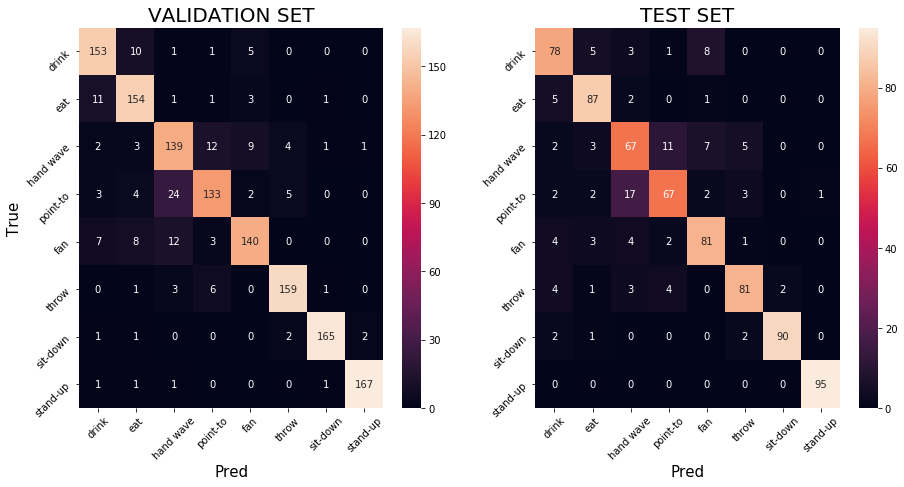

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Val acc: 0.27912087912087913
Test acc: 0.27140974967061926


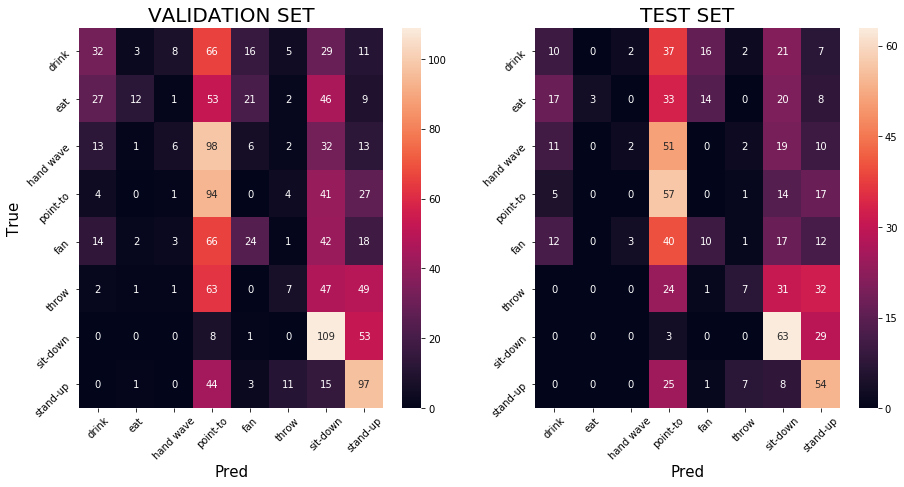

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame


KeyboardInterrupt: 

In [15]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        ## reshaping ###
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
        results.append((val_acc,test_acc,saved_model))

In [14]:
results

[(0.8864468864468864,
  0.8511198945981555,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5'>),
 (0.27912087912087913,
  0.27140974967061926,
  <DirEntry 'PoseNet-101-relativeToVideoCenter.h5'>),
 (0.8827838827838828,
  0.8313570487483531,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame.h5'>),
 (0.2293040293040293,
  0.21080368906455862,
  <DirEntry 'PoseNet-101-relativeToFrameCenter.h5'>),
 (0.1326007326007326,
  0.13175230566534915,
  <DirEntry 'PoseNet-101-relativeToVideoCenter-norm.h5'>),
 (0.18315018315018314,
  0.18972332015810275,
  <DirEntry 'PoseNet-101-relativeToFrameCenter-norm.h5'>),
 (0.8842490842490842,
  0.8642951251646904,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame-norm.h5'>),
 (0.28644688644688643,
  0.29907773386034253,
  <DirEntry 'PoseNet-101-relativeToNextFrame.h5'>),
 (0.21465201465201464, 0.2134387351778656, <DirEntry 'PoseNet-101-norm.h5'>),
 (0.136996336996337,
  0.13175230566534915,
  <DirEntry '

Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


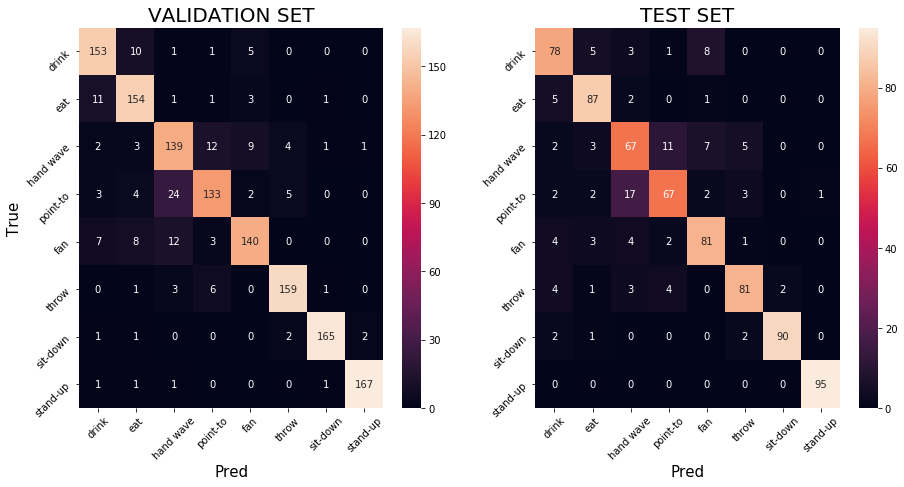

In [34]:
label_order = [1, 2, 31, 38, 49, 7, 8, 9]
model = loadedModel
y_val_pred = [label_order[i] for i in model.predict_classes(X_val)]
y_val_true = [label_order[np.argmax(i)] for i in y_val]
y_test_pred = [label_order[i] for i in model.predict_classes(X_test)]
y_test_true = [label_order[np.argmax(i)] for i in y_test]
val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
print("Val acc:",val_acc)
print("Test acc:",test_acc)
conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
plotConfusionMatrixes(conf_mat_val,conf_mat_test)

In [21]:
y_val_pred

[31,
 2,
 1,
 1,
 2,
 49,
 1,
 7,
 9,
 7,
 1,
 38,
 2,
 8,
 7,
 8,
 1,
 9,
 8,
 2,
 38,
 2,
 38,
 2,
 1,
 1,
 31,
 38,
 31,
 2,
 49,
 31,
 7,
 1,
 31,
 49,
 31,
 31,
 9,
 8,
 49,
 31,
 7,
 2,
 49,
 49,
 38,
 38,
 49,
 9,
 31,
 49,
 2,
 31,
 38,
 7,
 49,
 31,
 1,
 49,
 1,
 38,
 8,
 7,
 31,
 49,
 9,
 9,
 8,
 8,
 7,
 8,
 2,
 7,
 49,
 7,
 2,
 8,
 7,
 7,
 1,
 7,
 31,
 8,
 2,
 7,
 2,
 31,
 31,
 8,
 38,
 9,
 38,
 2,
 9,
 31,
 7,
 8,
 38,
 2,
 31,
 8,
 7,
 49,
 31,
 8,
 49,
 8,
 1,
 38,
 9,
 8,
 2,
 49,
 8,
 38,
 9,
 2,
 49,
 31,
 38,
 38,
 1,
 7,
 31,
 7,
 49,
 49,
 9,
 49,
 8,
 1,
 49,
 9,
 31,
 1,
 1,
 1,
 8,
 7,
 8,
 49,
 9,
 1,
 7,
 8,
 31,
 2,
 38,
 2,
 31,
 8,
 8,
 7,
 2,
 7,
 38,
 49,
 31,
 8,
 49,
 8,
 49,
 49,
 38,
 7,
 9,
 9,
 38,
 7,
 2,
 8,
 2,
 9,
 38,
 8,
 8,
 8,
 7,
 49,
 9,
 8,
 2,
 8,
 31,
 8,
 9,
 38,
 8,
 38,
 31,
 49,
 9,
 8,
 9,
 31,
 49,
 2,
 31,
 1,
 9,
 38,
 8,
 1,
 8,
 8,
 7,
 49,
 1,
 9,
 1,
 38,
 8,
 1,
 8,
 9,
 2,
 49,
 2,
 8,
 1,
 2,
 7,
 1,
 2,
 38,
 49,
 2,
 31,

In [128]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = getValTestAccuracy(loadedModel, X_val, y_val, X_test, y_test)
        print("Validation accuracy:",val_acc,"\nTest accuracy:",test_acc)
        results.append((basename(saved_model),val_acc, test_acc))
#         plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
print("DONE!")

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Validation accuracy: 0.8688644688644689 
Test accuracy: 0.8511198945981555
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each vid

In [114]:
loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)

## continue training

In [13]:
# modelName = 'simple-model.h5'

In [14]:
# from keras.models import load_model
# model = load_model(modelName)

#Continue training
# model.fit(second_training, second_classes, batch_size=32, nb_epoch=20)

# history = model.fit(X_train, y_train,
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
# #                     validation_split=0.2
#                     validation_data=(X_val, y_val)
#                    )

Train on 5460 samples, validate on 1365 samples
Epoch 1/10
5460/5460 [==============================] - 35s 6ms/step - loss: 1.2101 - accuracy: 0.4623 - val_loss: 1.2212 - val_accuracy: 0.4718
Epoch 2/10
 368/5460 [=>............................] - ETA: 29s - loss: 1.1121 - accuracy: 0.4810

KeyboardInterrupt: 

# Display classification

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score

label_order = [1, 2, 31, 38, 49, 7, 8, 9]
y_pred = loadedModel.predict_classes(X_val)
# label_order = ["1", "2", "31", "38", "49", "7", "8", "9"]
y_pred_labels = [label_order[i] for i in y_pred]
y_val_labels = [label_order[np.argmax(i)] for i in y_val]

In [45]:
accuracy_score(y_pred=y_pred_labels,y_true=y_val_labels)

0.8827838827838828

In [46]:
yTrue=y_pred_labels
yPred=y_test_labels
conf_mat = confusion_matrix(y_true=yTrue, y_pred=yPred, labels=label_order)
conf_mat

array([[133,  16,   4,   4,   8,   0,   0,   0],
       [ 10, 110,   4,   1,  12,   2,   0,   0],
       [  3,   5, 130,   8,   3,   4,   0,   0],
       [  6,   1,   2, 108,   6,   1,   1,   0],
       [  3,   4,   2,   1, 113,   1,   0,   0],
       [  0,   0,   3,   2,   0, 119,   0,   1],
       [  0,   0,   1,   0,   1,   2, 130,   0],
       [  0,   0,   1,   0,   0,   1,   4, 121]])

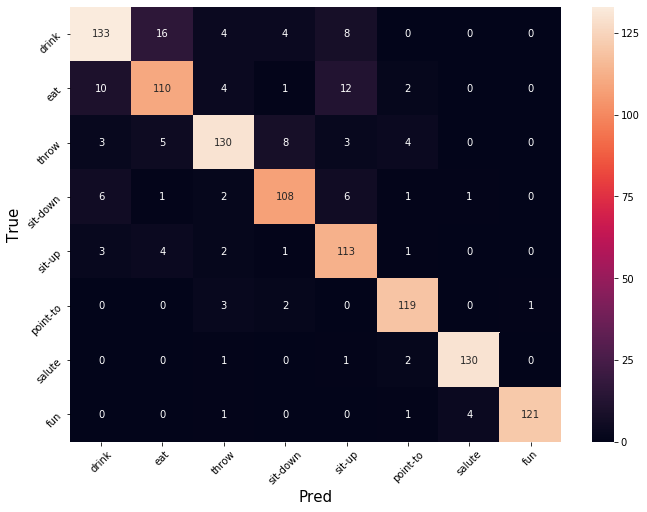

In [41]:
import seaborn as sn
plt.figure(figsize = (11,8))
ax = plt.axes()
labelString = ["drink", "eat", "throw", "sit-down", "sit-up", "point-to", "salute", "fun"]
ax = sn.heatmap(conf_mat, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# plt.title('', fontsize = 20) # title with fontsize 20
plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# ACTION_LABEL_SET = 
# A001  - A002 - A007 - A008     - A009   - A031               - A038   -  A049
# drink - eat - throw - sit down - sit up - point to something - salute - make a fun 


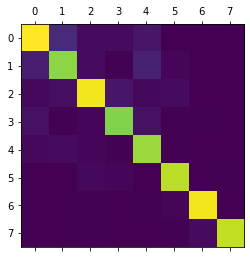

In [42]:
plt.matshow(conf_mat)